In [2]:
!pip install scanpy igraph leidenalg harmonypy

In [3]:
# Скачиваем датасет (smartseq2)
!wget -O GSE135045_RAW.tar "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE135045&format=file"

--2025-11-26 22:15:19--  https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE135045&format=file
Resolving www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)... 130.14.29.110, 2607:f220:41e:4290::110
Connecting to www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62064640 (59M) [application/x-tar]
Saving to: ‘GSE135045_RAW.tar’

GSE135045_RAW.tar   100%[===================>]  59.19M  33.3MB/s    in 1.8s    

2025-11-26 22:15:21 (33.3 MB/s) - ‘GSE135045_RAW.tar’ saved [62064640/62064640]



In [4]:
!mkdir -p gbm # распакуем в отдельную мамку
!tar -xvf GSE135045_RAW.tar -C gbm

GSM3984317_NO.1.expression_matrix.txt.gz
GSM3984318_NO.2.expression_matrix.txt.gz
GSM3984319_NO.3.expression_matrix.txt.gz
GSM3984322_NO.7.expression_matrix.txt.gz
GSM3984326_NO.12.expression_matrix.txt.gz
GSM3984330_NO.16.expression_matrix.txt.gz
GSM4495152_NO.20.expression_matrix.txt.gz


In [6]:
import os
import gzip
import pandas as pd
import scanpy as sc

path = "gbm" # папка куда мы скачали датасеты
# Находим все файлы с матрицами экспрессии.
files = sorted([f for f in os.listdir(path) if f.endswith(".txt.gz")]) # они заканчиваются на .txt.gz в данном случае
# Для платформы smartseq2 встречаются и другие расширения, например просто .txt, или .csv/.tsv
# В 10x Genomics-данных как правило встречается тройка файлов matrix.mtx + barcodes.csv + features.csv

In [7]:
adatas = []
# читаем данные в отдельные adata-объекты
# К сожалению все в RAM колаба не поместятся, так что загрузим только первые три
for f in files[:3]:
    sample_id = f.split("_")[0]      # идентификатор GSM, например GSM3984317, но можно задать свои названия, главное что бы каждый образец имел уникальное название

    file_path = os.path.join(path, f)

    print("Loading:", f)

    # Читаем gz файл напрямую в pandas
    df = pd.read_csv(file_path, sep="\t", index_col=0)

    # Проверяем ориентацию матрицы
    if df.shape[0] > df.shape[1]:
        # как правило: гены строки, клетки столбцы, а Scanpy хочет наоборот!
        df = df.T

    # Создаем AnnData
    adata = sc.AnnData(df)

    # Добавляем метаданные
    adata.obs["Sample"] = sample_id # проводить батч-коррекцию будем именно по этому идентификатору: он хранит информацию о том какие клетки к какому образцу относятся
    # Собираем
    adatas.append(adata)

Loading: GSM3984317_NO.1.expression_matrix.txt.gz
Loading: GSM3984318_NO.2.expression_matrix.txt.gz
Loading: GSM3984319_NO.3.expression_matrix.txt.gz


In [36]:
adatas # получаем три объекта

[AnnData object with n_obs × n_vars = 4466 × 35966
     obs: 'Sample',
 AnnData object with n_obs × n_vars = 2643 × 28928
     obs: 'Sample',
 AnnData object with n_obs × n_vars = 3196 × 30281
     obs: 'Sample']

In [8]:
import gc
# объединяем все образцы в единый adata объект
adata_merged = adatas[0].concatenate(
    adatas[1:],
    batch_key="Sample",
    batch_categories=[a.obs["Sample"][0] for a in adatas]
)
# чистим за собой
del adatas
gc.collect()

/tmp/ipython-input-3527694559.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  batch_categories=[a.obs["Sample"][0] for a in adatas]
/tmp/ipython-input-3527694559.py:3: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_merged = adatas[0].concatenate(


55

In [9]:
adata_merged

AnnData object with n_obs × n_vars = 10305 × 24511
    obs: 'Sample'

In [10]:
# Базовый пайплайн обработки signle cell RNA-seq данных
def main_pipeline(adata, n_components=15, resolution=0.1):
    adata = adata.copy() # Копия нужна, чтобы объект можно было менять без ошибок
    # -----------------------------------------Normalization-----------------------------------------------
    sc.pp.normalize_total(adata, target_sum=1e4)  # CPM normalization
    sc.pp.log1p(adata)  # Log-transform

    # -----------------------------------------FindVariableFeatures-----------------------------------------------
    sc.pp.highly_variable_genes(
        adata,
        n_top_genes=2000,
        flavor='seurat',
    )
    # -----------------------------------------Scaling-----------------------------------------------
    sc.pp.scale(adata, max_value=10)  # Z-score normalization
    # -----------------------------------------PCA-----------------------------------------------
    sc.tl.pca(adata, svd_solver='arpack', n_comps=n_components)
    # -----------------------------------------Clustering-----------------------------------------------
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=n_components)
    sc.tl.leiden(adata, resolution=resolution, key_added='clusters')
    # -----------------------------------------UMAP-----------------------------------------------
    sc.tl.umap(adata, n_components=2)
    return adata

In [11]:
adata_merged_intact = main_pipeline(adata_merged)

/tmp/ipython-input-3016099072.py:20: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=resolution, key_added='clusters')


In [12]:
import matplotlib.pyplot as plt
from matplotlib import cm

# просто функция для отрисовки основных маркеров
def plot_patterns(adata):
  fig, axes = plt.subplots(1, 4, figsize=(15, 5))  # 1 ряд, 2 колонки

  sc.pl.umap(adata, color='PTPRZ1', ax=axes[0], show=False, cmap=cm.plasma)
  axes[0].set_title('Glioblastoma cells (PTPRZ1+)')
  sc.pl.umap(adata, color='PTPRC', ax=axes[1], show=False, cmap=cm.plasma)
  axes[1].set_title('Immune cells (CD45+)')
  sc.pl.umap(adata, color='RGS5', ax=axes[2], show=False, cmap=cm.plasma)
  axes[2].set_title('Pericytes (RGS5+)')
  sc.pl.umap(adata, color='PECAM1', ax=axes[3], show=False, cmap=cm.plasma)
  axes[3].set_title('Endothelial cells (CD31+)')

  plt.tight_layout()
  plt.show()

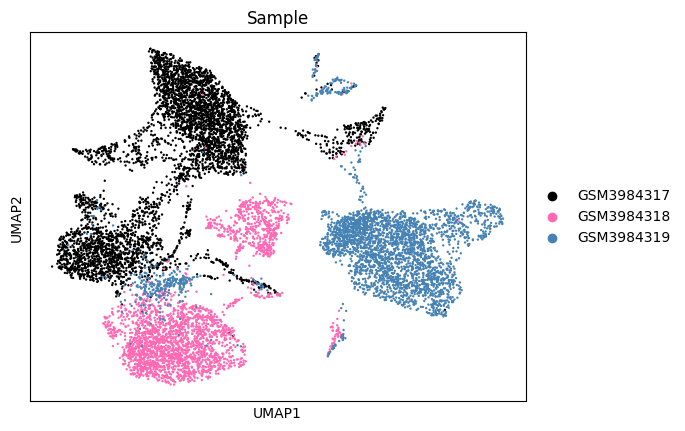

In [30]:
sc.pl.umap(
    adata_merged_intact,
    color='Sample',
    palette=['black', 'hotpink', 'steelblue'] # Мы взяли три образца, для большего количества образцов понадобится больше цветов
)

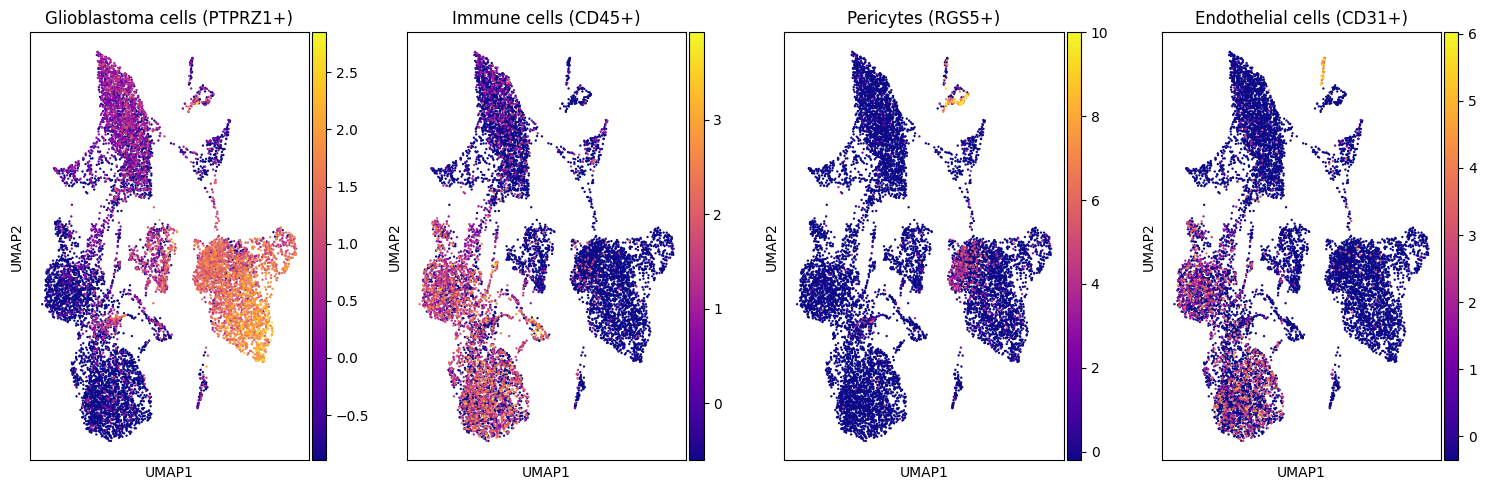

In [13]:
plot_patterns(adata_merged_intact) # UMAP картина без батч-коррекции

In [18]:
import scanpy as sc
import scanpy.external as sce

# Пайплайн уже с harmony: мы запускаем его после PCA, потому что
# Harmony корректирует PC компоненты для фильтрации шума, и не трогает исходную экспрессию генов
def main_pipeline_harmony(
    adata,
    batch_key="Sample",      # колонка в adata.obs, по которой корректируем батчи
    n_components=15,
    resolution=0.1
):
    adata = adata.copy()

    # ----------------------------------------- Normalization -----------------------------------------------
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # ----------------------------------------- FindVariableFeatures ----------------------------------------
    sc.pp.highly_variable_genes(
        adata,
        n_top_genes=2000,
        flavor='seurat',
    )

    # (опционально) оставить HVG:
    # adata = adata[:, adata.var['highly_variable']].copy()

    # ----------------------------------------- Scaling ------------------------------------------------------
    sc.pp.scale(adata, max_value=10)

    # ----------------------------------------- PCA ----------------------------------------------------------
    sc.tl.pca(adata, svd_solver='arpack', n_comps=n_components)

    # ----------------------------------------- Harmony batch correction ------------------------------------
    # Harmony создает новую матрицу в adata.obsm["X_pca_harmony"]
    sce.pp.harmony_integrate(adata, key=batch_key)

    # ----------------------------------------- Clustering ----------------------------------------------------
    sc.pp.neighbors(
        adata,
        use_rep="X_pca_harmony",   # используем harmony скорректированные PC
        n_neighbors=10,
        n_pcs=n_components
    )
    sc.tl.leiden(adata, resolution=resolution, key_added='clusters')

    # ----------------------------------------- UMAP ---------------------------------------------------------
    sc.tl.umap(adata, n_components=2)

    return adata


In [19]:
adata_merged_harmony = main_pipeline_harmony(adata_merged)

2025-11-26 22:33:52,450 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-11-26 22:33:55,063 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-11-26 22:33:55,137 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-11-26 22:34:01,001 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-11-26 22:34:05,333 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-11-26 22:34:10,145 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-11-26 22:34:16,079 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-11-26 22:34:25,543 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-11-26 22:34:33,073 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-11-26 22:34:37,337 - 

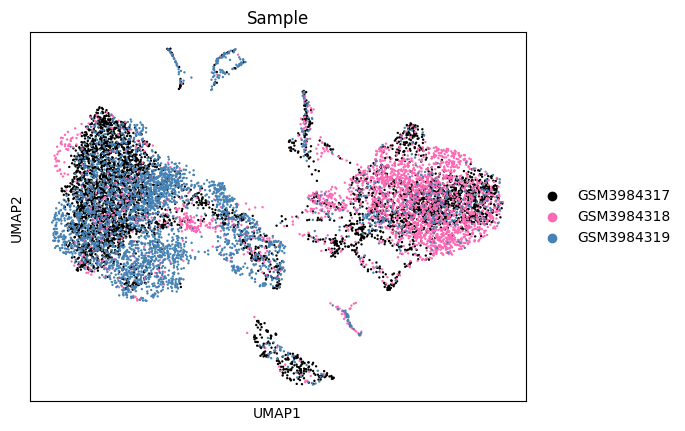

In [31]:
sc.pl.umap(
    adata_merged_harmony,
    color='Sample',
    palette=['black', 'hotpink', 'steelblue']
)

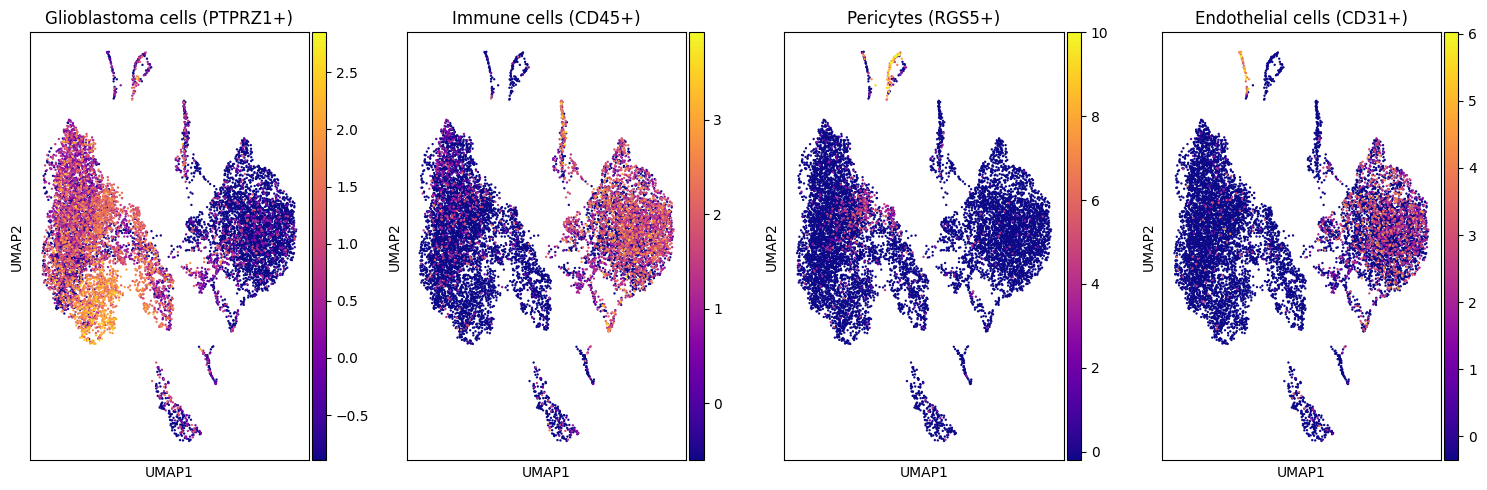

In [15]:
plot_patterns(adata_merged_harmony)